# Parameter sensitivity

Are k-MSTs less sensitive to k than k-NNs? Intuitively the answer is yes because
k-MSTs always produce a single connected component for every value of k. That is
not always the case for k-NNs. 

A better question is asks how k influences dimensionality reduction performance.
That is more difficult to evaluate because DR quality measures are expensive to
compute and the difference between k-MSTs and k-NNs is more likely to occur on
larger datasets. Additionally, DR quality measures are not always sensitive to
visual changes in global structure, making their comparison difficult to
interpret.

Instead, this notebook compares embeddings visually using UMAP, tSNE, and SFDP
layouts to demonstrate k-MSTs produces usable and interpretable embeddings at
$k=3$ for a range of datasets. In addition, we show k-NNs need larger values of
k on some data sets to produce similarly interpretable embeddings.

Improvements:
- User study to judge interpretability?
- Quantitative parameter sensitivity -> Measure change interpretability for perturbations of k

In [2]:
import cuml
import warnings
import numpy as np
import pandas as pd
import lensed_umap as lu
from tqdm import tqdm
from itertools import product
from scipy.sparse import csr_array
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_openml

from umap import UMAP
from multi_mst import KMST, KMSTDescent

## Datasets

In [3]:
def load_horse():
    return pd.read_csv("./data/horse/horse.csv").to_numpy()


def load_elegans():
    return normalize(
        pd.read_csv("./data/elegans/elegans_preprocessed.csv", index_col=0).to_numpy()
    )


def load_mnist():
    return fetch_openml("mnist_784", version=1).data

## Compare DR layouts (UMAP, tSNE)

The cells in this section load and pre-process the datasets (where neccesary).

These cells define functions to evaluate each algorithm.

In [3]:
def compute_umap(data, k):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        p = UMAP(n_neighbors=k).fit(data, transform_mode="graph")
        p = lu.cuml_embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 0.5])
    return p.embedding_, p.graph_

In [4]:
def compute_kmst(data, k):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        if data.shape[1] > 10:
            p = KMSTDescent(num_neighbors=k).fit(data).umap(transform_mode="graph")
        else:
            p = KMST(num_neighbors=k).fit(data).umap(transform_mode="graph")
        p = lu.cuml_embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 0.5])
    return p.embedding_, p.graph_

In [5]:
def compute_tsne(data, k):
    # TSNE turns perplexity into num_neighbors as: (perplexity * 3) + 1
    with cuml.using_output_type("numpy"):
        return cuml.TSNE(perplexity=(k - 1) / 3).fit_transform(data), None

Run all algorithm--data set--$k$ combinations:

In [6]:
algorithms = {"tsne": compute_tsne, "kmst": compute_kmst, "umap": compute_umap}
data = {"elegans": load_elegans, "horse": load_horse, "mnist": load_mnist}
ks = [2, 3, 4, 5, 7, 10]

records = []
pbar = tqdm(total=len(ks) * len(data) * len(algorithms))
for data_name, loader in data.items():
    X = loader()
    for (algorithm, fun), k in product(algorithms.items(), ks):
        embedding, graph = fun(X, k)
        records.append(
            {
                "data_set": data_name,
                "algorithm": algorithm,
                "k": k,
                "embedding": embedding,
                "graph": graph,
            }
        )
        pbar.update(1)

df = pd.DataFrame.from_records(records)

  2%|█▌                                                                                | 1/54 [00:01<01:03,  1.19s/it]

[2025-09-02 11:33:00.598] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:01.503] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


  6%|████▌                                                                             | 3/54 [00:02<00:38,  1.31it/s]

[2025-09-02 11:33:02.147] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:02.782] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


  9%|███████▌                                                                          | 5/54 [00:03<00:34,  1.43it/s]

[2025-09-02 11:33:03.436] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:04.093] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 35%|████████████████████████████▌                                                    | 19/54 [00:30<00:31,  1.11it/s]

[2025-09-02 11:33:30.356] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:31.245] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 39%|███████████████████████████████▌                                                 | 21/54 [00:32<00:26,  1.24it/s]

[2025-09-02 11:33:31.986] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:32.682] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 43%|██████████████████████████████████▌                                              | 23/54 [00:33<00:23,  1.33it/s]

[2025-09-02 11:33:33.383] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:34.090] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 69%|███████████████████████████████████████████████████████▌                         | 37/54 [00:49<00:34,  2.04s/it]

[2025-09-02 11:33:47.927] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:50.319] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 72%|██████████████████████████████████████████████████████████▌                      | 39/54 [00:54<00:31,  2.07s/it]

[2025-09-02 11:33:52.445] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:54.516] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


 76%|█████████████████████████████████████████████████████████████▌                   | 41/54 [00:58<00:27,  2.08s/it]

[2025-09-02 11:33:56.597] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[2025-09-02 11:33:58.691] [CUML] [warning] Perplexity should be within ranges (5, 50). Your results might be a bit strange...


100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [04:06<00:00, 11.47s/it]

In [7]:
df.to_pickle("./data/benchmark_sensitivity.pkl")

### Results

In [8]:
import numpy as np
import pandas as pd
from lib.plotting import *


_ = configure_matplotlib()
df = pd.read_pickle("./data/benchmark_sensitivity.pkl")

ks = sorted(df.k.unique())
algorithms = ["kmst", "umap", "tsne"]
datasets = sorted(df.data_set.unique())

Configure value renaming for plots:

In [9]:
def to_display_name(name):
    if name == "kmst":
        return "$k$-MST"
    if name == "umap":
        return "UMAP"
    if name == "tsne":
        return "t-SNE"
    return name

Embedding small-multiples

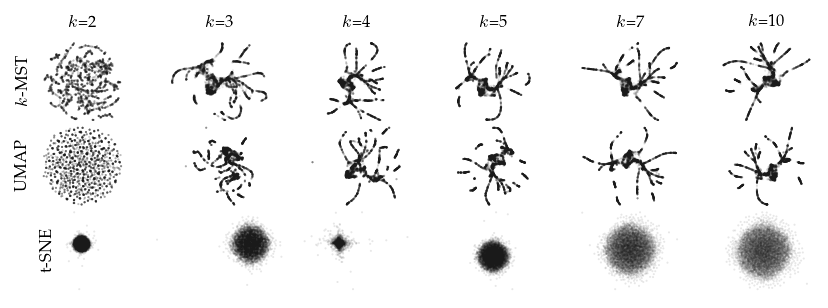

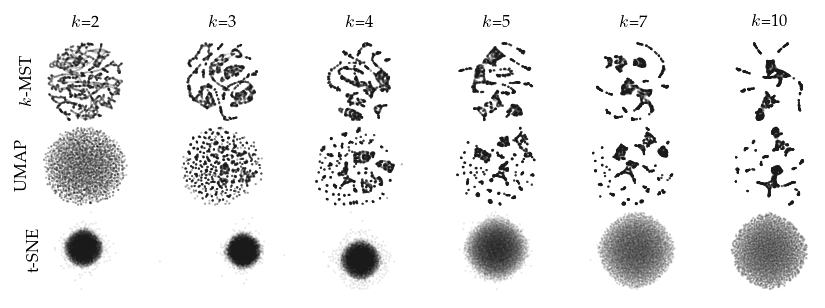

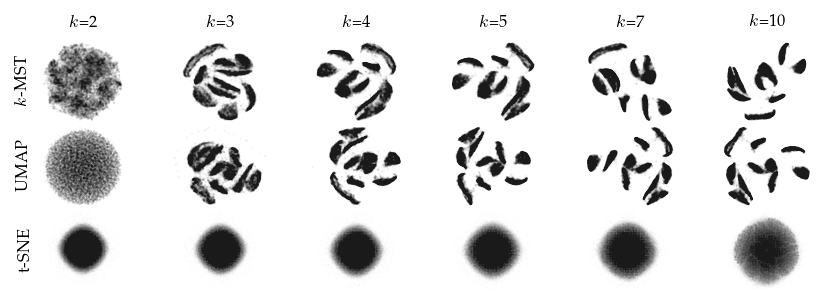

In [12]:
for data_set in datasets:
    sized_fig(1, 0.618 / 6 * 3)
    for i, (alg, k) in enumerate(product(algorithms, ks)):
        plt.subplot(len(algorithms), len(ks), i + 1)
        row = df.query("data_set == @data_set & k == @k & algorithm == @alg")
        embedding = row.embedding.iloc[0]
        plt.scatter(
            *embedding.T,
            s=1,
            alpha=0.01 if data_set == "mnist" else 0.1,
            color="k",
            edgecolors="none",
        )
        plt.xticks([])
        plt.yticks([])
        frame_off()
        if alg == algorithms[0]:
            plt.title(f"$k$={k}", fontsize=8)
        if k == ks[0]:
            plt.ylabel(to_display_name(alg), fontsize=8)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.show()

## Compare force layouts

In [24]:
import networkx as nx


def layout_graph(graph):
    g = nx.Graph(graph)
    pos = nx.nx_agraph.graphviz_layout(g, prog="sfdp")
    coords = np.nan * np.ones((graph.shape[0], 2), dtype=np.float64)
    for k, v in pos.items():
        coords[k, :] = v
    return coords


def run_benchmark(data_name, data, k):
    alg = KMSTDescent if data.shape[1] > 10 else KMST
    model = alg(num_neighbors=k).fit(data)

    kmst_graph = model.graph_.copy()
    kmst_graph.eliminate_zeros()
    kmst_graph.sort_indices()

    knn_dists = model.knn_distances_.copy()
    knn_indices = model.knn_neighbors_.copy()
    knn_graph = csr_array(
        (
            knn_dists.ravel(),
            knn_indices.ravel(),
            np.arange(knn_dists.shape[0]+1) * knn_dists.shape[1],
        ),
        shape=(data.shape[0], data.shape[0]),
    )
    knn_graph.eliminate_zeros()
    knn_graph.sort_indices()

    return [
        {
            "data_set": data_name,
            "algorithm": "kmst",
            "k": k,
            "graph": kmst_graph,
            "embedding": layout_graph(kmst_graph),
        },
        {
            "data_set": data_name,
            "algorithm": "knn",
            "k": k,
            "graph": knn_graph,
            "embedding": layout_graph(knn_graph),
        },
    ]

In [25]:
data = {"elegans": load_elegans, "horse": load_horse, "mnist": load_mnist}
ks = [2, 3, 4, 5, 7, 10]

records = []
pbar = tqdm(total=len(ks) * len(data))
for data_name, loader in data.items():
    X = loader()
    for k in ks:
        records.extend(run_benchmark(data_name, X, k))
        pbar.update(1)

df = pd.DataFrame.from_records(records)

100%|█████████████████████████████████████████████████████████████████████████| 18/18 [10:25<00:00, 87.84s/it]

In [26]:
df.to_pickle("./data/benchmark_sensitivity_force_layouts.pkl")

In [32]:
from lib.plotting import *


def to_display_name(name):
    if name == "kmst":
        return "$k$-MST"
    if name == "knn":
        return "$k$-NN"
    return name


_ = configure_matplotlib()
ks = sorted(df.k.unique())
algorithms = ["kmst", "knn"]
datasets = sorted(df.data_set.unique())

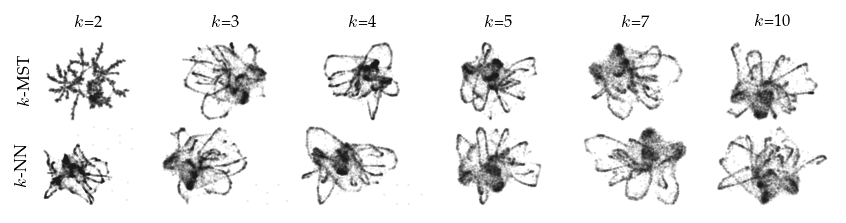

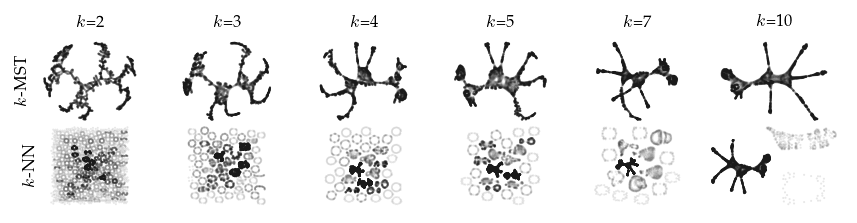

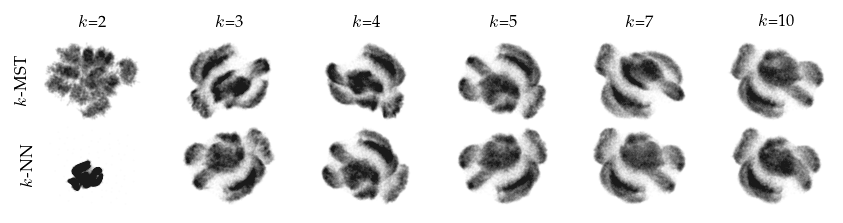

In [33]:
for data_set in datasets:
    sized_fig(1, 0.618 / 6 * 2)
    for i, (alg, k) in enumerate(product(algorithms, ks)):
        plt.subplot(len(algorithms), len(ks), i + 1)
        row = df.query("data_set == @data_set & k == @k & algorithm == @alg")
        embedding = row.embedding.iloc[0]
        plt.scatter(
            *embedding.T,
            s=1,
            alpha=0.01 if data_set == "mnist" else 0.1,
            color="k",
            edgecolors="none",
        )
        plt.xticks([])
        plt.yticks([])
        frame_off()
        if alg == algorithms[0]:
            plt.title(f"$k$={k}", fontsize=8)
        if k == ks[0]:
            plt.ylabel(to_display_name(alg), fontsize=8)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.show()